In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram
from toolz import pipe
%matplotlib inline

In [2]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.display import display
import IPython.html.widgets as widgets
from IPython.utils.traitlets import link as traitlink

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
summary = pd.read_csv('../output/condition_summary.csv')

In [4]:
def filter_and_drop(df,col,val):
    """ Return DataFrame with rows that match filter. Filter column is dropped. """
    return df[df[col] == val].drop([col],axis=1)

def get_means(df):
    """ Get means from data. """
    return filter_and_drop(df,'Function','mean')

def normalize_columns(df):
    """ Return new DataFrame, where the norm of each column is the unit value. """
    return df.apply(lambda x: x.values/np.linalg.norm(x.values))

In [5]:
# Test normalize_columns
#np.linalg.norm(test[test.columns[1]].values)

In [6]:
data = pipe(summary,
            get_means,
            lambda df: df.set_index('Condition'),
            normalize_columns)

In [7]:
# Need to improve this chunk of code. It's important, but difficult to read. 

def plot_matrix_tree(matrix,xlink,ylink,xlabels,ylabels):
    plt.figure(figsize=(20,10))
    plt.subplots_adjust(hspace=0,wspace=0)
    gs = gridspec.GridSpec(2, 1,height_ratios=[1,5]) 
    
    def subplot_dendrogram(subplot,link,orientation):
        plt.subplot(subplot)
        dendrogram(link, orientation = orientation, link_color_func = lambda x: 'k')
        plt.axis('off')

    subplot_dendrogram(gs[0],xlink,'top')
    
    plt.subplot(gs[1])
    plt.imshow(matrix,interpolation='nearest',cmap='Blues',aspect='auto');
    [plt.gca().spines[loc].set_visible(False) for loc in ['top','bottom','left','right']]
    
    plt.xticks(range(len(xlabels)),xlabels,rotation=30,ha='right')
    plt.yticks(range(len(ylabels)),ylabels)

def matrix_tree(data):
    normed_data = data.values

    condition_link = linkage(normed_data)
    feature_link = linkage(normed_data.T)

    condition_order = leaves_list(condition_link)
    feature_order = leaves_list(feature_link)

    conditions = data.index.values[condition_order]
    features = data.columns.values[feature_order]

    color_matrix = normed_data.T[feature_order,:][:,condition_order]
    
    plot_matrix_tree(color_matrix,
                     condition_link,
                     feature_link,
                     conditions,
                     features)

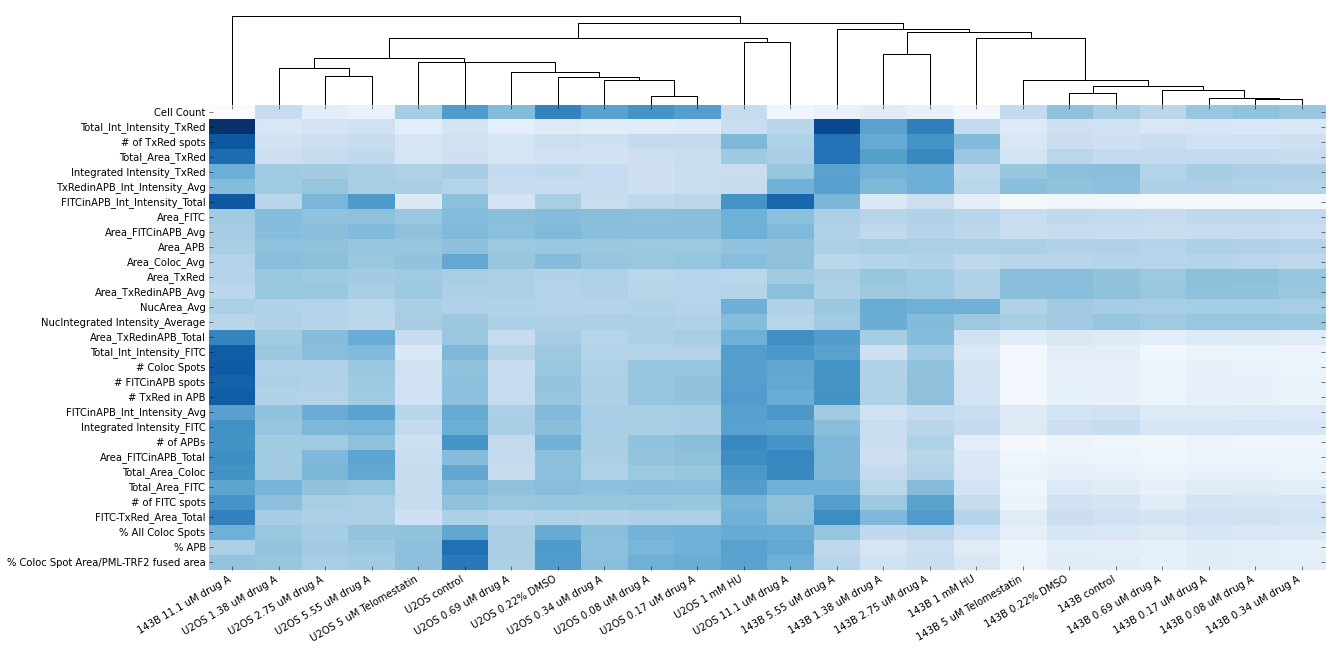

In [8]:
matrix_tree(data)

In [9]:
x1 = widgets.VBox([interactive(matrix_tree,data = fixed(data))])
x2 = interactive(matrix_tree,data = fixed(data))

tabs = widgets.TabWidget(children = [x1,widgets.VBox([subset])])
tabs.set_title(0, 'Master View')
tabs

/home/carlos/anaconda/lib/python2.7/site-packages/pandas/core/internals.py:850: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return self._try_coerce_result(func(values, other))


NameError: name 'subset' is not defined

In [ ]:
widgets.VBox([interactive(matrix_tree,data = fixed(data))])

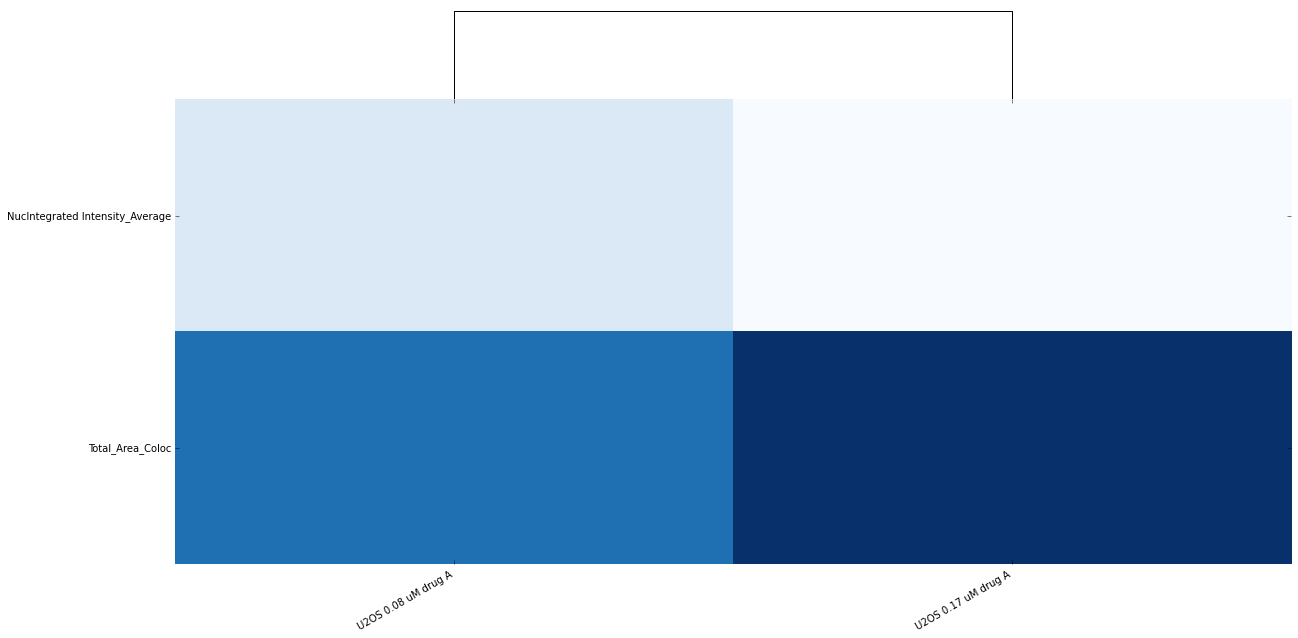

In [17]:
# v_container = widgets.VBox()

# # Display the container
# display(v_container)

# # Define Widgets
# for counter in range(5):
#     wgt_check = widgets.CheckboxWidget()
#     wgt_text = widgets.TextWidget(description="Name")
#     wgt_select = widgets.DropdownWidget(values=["Guest", "User", "Admin"])

#     # Add Widgets
#     h_container = widgets.HBox()
#     h_container.children += (wgt_check, wgt_text, wgt_select)
#     v_container.children += (h_container,)

# wgt_button = widgets.ButtonWidget(description="Submit")
# v_container.children += (wgt_button,)

def show_widget_grid(grid):
    v_container = widgets.VBox()
    display(v_container)
    for row in grid: 
        h_container = widgets.HBox()
        h_container.children = row
        v_container.children += (h_container,)

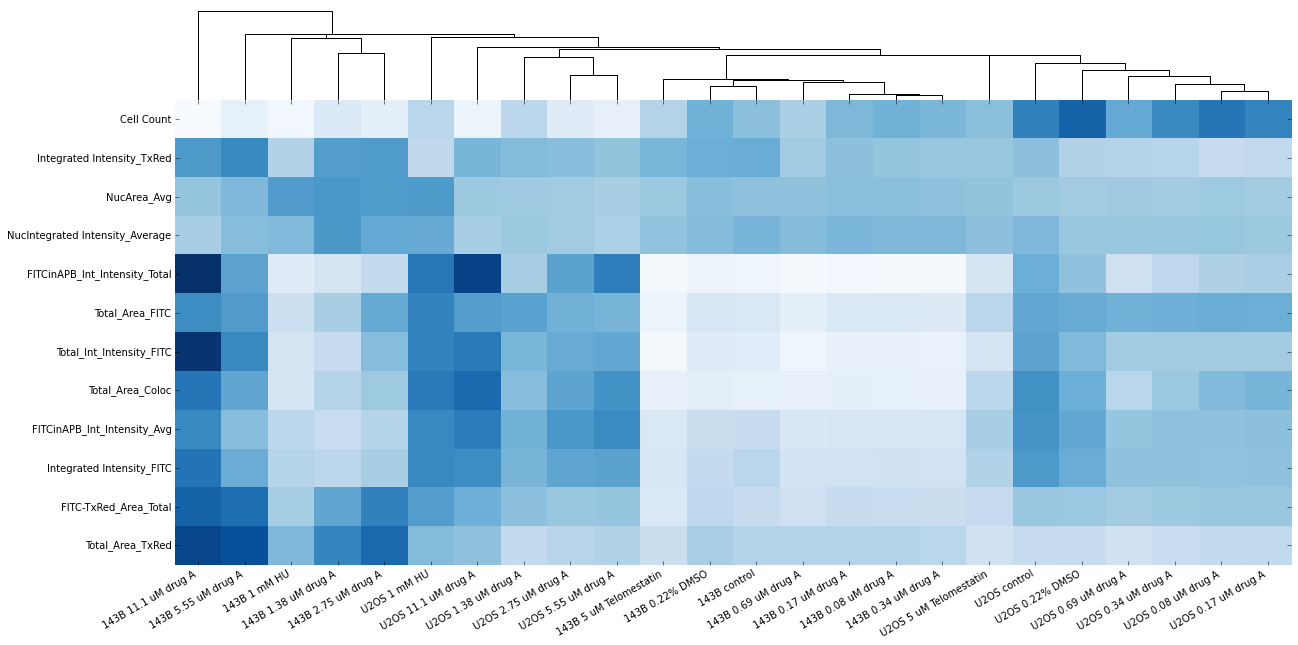

In [20]:
# interactive(wrapper,
#          conditions = widgets.SelectMultiple(options = data.index.values.tolist()),
#          features = widgets.SelectMultiple(options = data.columns.values.tolist()))


def wrapper(conditions,features):
    conditions = condition_selector.value
    features = feature_selector.value
    df = data.loc[list(conditions)][list(features)]
    matrix_tree(df)

condition_selector = widgets.SelectMultiple(options = data.index.values.tolist())
feature_selector = widgets.SelectMultiple(options = data.columns.values.tolist())
plotter = interactive(wrapper, conditions = condition_selector, features = feature_selector )

# grid = [[condition_selector,feature_selector,plotter]]
# show_widget_grid(grid)
plotter

In [13]:
widgets.Widget

IPython.html.widgets.widget.Widget

In [28]:
class myClass(widgets.Widget):
    def __init__(self):
        self.x = 1
    def _handle_displayed(self):
        print "bob"

In [29]:
mc = myClass()

In [30]:
slider = widgets.IntSlider(min=0, max =100)
def print_func(x):
    print x
printer = interactive(print_func, x=fixed(5))
# traitlink((slider,'value'),(printer.children[0],'value'))

display(widgets.HBox(children=[slider,mc]))

AttributeError: 'NoneType' object has no attribute 'comm_id'

# Correlations

In [31]:
from scipy.stats import spearmanr, pearsonr

In [51]:
cdata = data.transpose()
def compare_conditions(a,b):
    x = cdata[a].values
    y = cdata[b].values
    plt.plot(x,y,'o')
    xr = np.linspace(0,max(x.max(),y.max()),100)
    plt.plot(xr,xr,'r')
    print "Spearman: {} \n Pearson: {}".format(spearmanr(x,y),pearsonr(x,y))

In [52]:
from IPython.html.widgets import interact

Spearman: (-0.9975806451612903, 3.8809520791980237e-35) 
 Pearson: (-0.99764908817579789, 2.5609986544719368e-35)


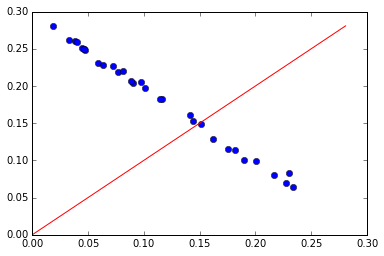

In [53]:
interact(compare_conditions, a = cdata.columns.values.tolist(), b = cdata.columns.values.tolist());

Spearman: (1.0, 0.0) 
 Pearson: (1.0, 0.0)


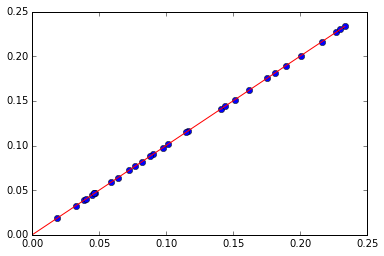

In [17]:
interact(compare_conditions, a = cdata.columns.values.tolist(), b = cdata.columns.values.tolist());

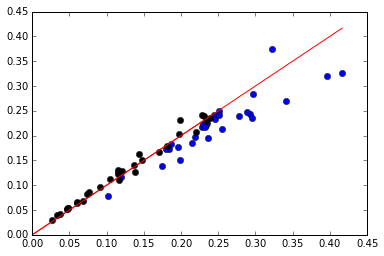

In [18]:
x = cdata['U2OS control'].values
y = cdata['U2OS 0.22% DMSO'].values
plt.plot(x,y,'bo')
xr = np.linspace(0,max(x.max(),y.max()),100)
plt.plot(xr,xr,'r')

x = cdata['143B control'].values
y = cdata['143B 0.22% DMSO'].values
plt.plot(x,y,'ko')
xr = np.linspace(0,max(x.max(),y.max()),100)
plt.plot(xr,xr,'r');

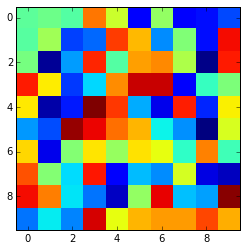

In [91]:
plt.imshow(np.random.random([10,10]),interpolation='nearest')

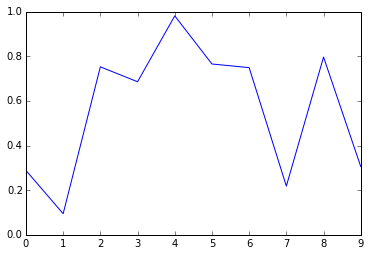

In [92]:
plt.plot(range(10),np.random.random(10))

In [145]:
h = widgets.HBox([widgets.IntSlider(min=100,max=1000),widgets.IntSlider(min=100,max=1000)])
def plot_stuff(name):
    x = range(h.children[0].value)
    y = np.random.randn(h.children[0].value) * h.children[1].value
    plt.gca().cla()
    plt.plot(x,y)
h.children[0].on_trait_change(plot_stuff,'value')

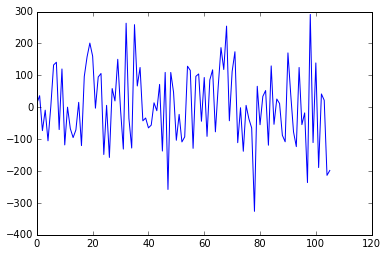

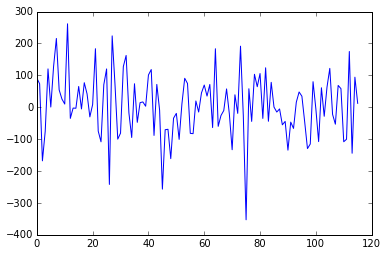

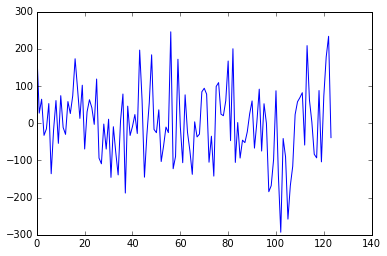

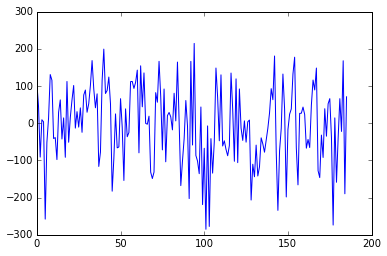

In [146]:
h